# Imports

In [1]:
import sys, os
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/fig"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src/data"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src/output"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src"))
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from stimuli import prefixes, prompts
import json

In [2]:
# set some matplotlib options to handle text better
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc("font", size=11)

# Define directories

In [3]:
home_dir = os.path.join(os.environ['homepath'], "project", "lm-mem")
data_dir = os.path.join(home_dir, "data", "output_cshift")
savedir = os.path.join(home_dir, "fig", "cshift")
table_savedir = os.path.join(home_dir, "tables")
savefigs = True

# Helper functions

### plot_example()

In [4]:
#wrapper function
def plot_example(x, y, markers, xlabels, ylabel, fh, fw, title):

    f, a = plt.subplots(figsize=(fw, fh))

    a.plot(x, y, marker=".", markerfacecolor="white", linestyle="--", linewidth=1)
    
    x_rect = np.where(l==l[m==3][0])[0]
    y_rect = a.get_ylim()[0]
                      
    for i, xloc in enumerate(x_rect):             
        a.add_patch(Rectangle(xy=(xloc-0.5, y_rect), width=len(l[m==1]), height=a.get_ylim()[-1]+0.5, 
                               edgecolor=None, facecolor="tab:blue", alpha=0.15))
        
    a.set_xticks(x);
    a.set_xticklabels(l, rotation=40, fontsize=12, ha="right");

    bluewords = np.isin(m, [1, 3])

    [t.set_color("tab:blue") for i, t in enumerate(a.xaxis.get_ticklabels()) if bluewords[i]]

    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.set(ylabel=ylabel, title=title);
    
    return f, a

### make_bar_plot()

In [5]:
def make_bar_plot(data_frame, x, y, hue, col,
                  ylim=None, xlabel=None, ylabel=None, suptitle=None,
                  size_inches=(5, 3), legend=False, legend_out=False, legend_title=None,
                  point_cloud_alpha=0.05, facecolor=(1, 1, 1, 0),
                  hue_order=["Novel", "Permuted", "Repeated"], col_order=["arbitrary", "semantic"]):


    g = sns.catplot(data=data_frame, x=x, y=y, hue=hue, col=col, 
                    estimator=np.median, ci=95.0,
                    kind="bar", dodge=0.5, palette="tab10", zorder=2, legend=legend, legend_out=legend_out,
                    seed=12345,
                    hue_order=hue_order, col_order=col_order,
                    facecolor=facecolor, edgecolor=["tab:gray"], ecolor=["tab:gray"], bottom=0, linewidth=1)
    
    ax = g.axes[0]

    # right panel
    select = (data_frame[col]==col_order[0])
    sns.stripplot(ax=ax[0], data=data_frame[select], x=x, y=y, hue=hue, hue_order=hue_order,
                   palette="pastel", dodge=0.5, alpha=0.05, zorder=1)

    # right panel
    for j, a in enumerate(ax):
        select = (data_frame[col]==col_order[j])
        sns.stripplot(ax=ax[j], data=data_frame[select], x=x, y=y, hue=hue, hue_order=hue_order,
                      palette="pastel", dodge=0.5, alpha=point_cloud_alpha, zorder=1)

    # set labels
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    if len(ax) == 2:
        ax[1].set_xlabel(xlabel)
        ax[1].set_ylabel("")
        
    # set ylim if needed
    if ylim is not None:
        ymin, ymax = ylim
        if ymin is None: ymin = ax[0].get_ylim()[0]
        if ymax is None: ymax = ax[0].get_ylim()[1]
        
        ax[0].set(ylim=(ymin, ymax))
    
    blue, orange, green = sns.color_palette("dark")[0:3]
    n_x_groups = len(data_frame[x].unique())
    for i, a in enumerate(ax):
        for patch in a.patches[0:n_x_groups]:
            patch.set_edgecolor(blue)
        for patch in a.patches[n_x_groups:n_x_groups*2]:
            patch.set_edgecolor(orange)
        for patch in a.patches[n_x_groups*2::]:
            patch.set_edgecolor(green)
    
    # annotate
    x_levels = data_frame.loc[:, x].unique()
    col_levels = data_frame.loc[:, col].unique()
    hue_levels = data_frame.loc[:, hue].unique()
    
    # find n rows for one plotted group
    one_group = (data_frame[x]==x_levels[0]) & (data_frame[hue]==hue_levels[0]) & (data_frame[col] == col_levels[0])
    n = len(data_frame.loc[one_group])  
    print("N per group == {}".format(n))
    # ax[0].text(x=ax[0].get_xlim()[0], y=ax[0].get_ylim()[-1]*0.9, s="N = {}".format(n))
    
    # find numerical values
    ci = {}
    for k, a in enumerate(ax):
        d = {lab: [] for lab in hue_order}
        ci[col_order[k]] = {"{}-{}".format(lab, x_levels[j]): plot_obj[0].get_ydata().tolist() + [plot_obj[1].get_height()]
                                                           for i, lab in enumerate(hue_order)
                                                           for j, plot_obj in enumerate(zip(a.lines[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)],
                                                                                            a.patches[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)]))}
    
    # convert dict to a "record" list with observation per row                                                      
    rec = [[key1, key.split("-")[0], key.split("-")[1], ci[key1][key][0], ci[key1][key][1], ci[key1][key][2]] for key1 in ci.keys() for key in ci[key1].keys()]
    
    ci_df = pd.DataFrame.from_records(rec, columns=[col, hue, x, "ci_min", "ci_max", "median"])
    
    # legend
    # Improve the legend
    if not legend:
        
        axis_with_legend = 0
        if len(ax) == 2:
            axis_with_legend = 1
            ax[0].get_legend().remove()
        
        handles, labels = ax[axis_with_legend].get_legend_handles_labels()
        ax[axis_with_legend].legend(handles[0:3], labels[0:3],
                                    handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1),
                                    loc="upper left", ncol=1, frameon=False, title=legend_title)

    g.fig.suptitle("{}".format(suptitle))
    g.set_titles(col_template="{col_name} lists of nouns")
    #g.despine(left=True)
    g.fig.set_size_inches(size_inches[0], size_inches[1])
    
    return g, ax, ci_df

### make_point_plot()

In [6]:
def make_point_plot(data_frame, x, y, hue, col,
                   xlabel=None, ylabel=None, suptitle=None, ylim=(None, None),
                   size_inches=(5, 3), join=True, scale=1, errwidth=None,
                   legend=False, legend_out=False, custom_legend=True, legend_title=None, 
                   hue_order=["Novel", "Permuted", "Repeated"], col_order=["arbitrary", "semantic"]):

    g = sns.catplot(data=data_frame, x=x, y=y, hue=hue, col=col, 
                    estimator=np.median, ci=95.0,
                    kind="point", join=join, dodge=0.2, scale=scale, errwidth=errwidth,
                    palette="tab10", zorder=2, legend=legend, legend_out=legend_out,
                    seed=12345,
                    hue_order=hue_order, col_order=col_order,
                    facecolor=(1, 1, 1, 0), edgecolor=["tab:gray"], ecolor=["tab:gray"], bottom=0, linewidth=1, ms=0.2)
    
    ax = g.axes[0]

    # set labels
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel("")
    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    
    # set ylim if needed
    if ylim is not None:
        ymin, ymax = ylim
        if ymin is None: ymin = ax[0].get_ylim()[0]
        if ymax is None: ymax = ax[0].get_ylim()[1]
        
        ax[0].set(ylim=(ymin, ymax))
    
    blue, orange, green = sns.color_palette("dark")[0:3]
    n_x_groups = len(data_frame[x].unique())
    
    # annotate
    x_levels = data_frame.loc[:, x].unique()
    col_levels = data_frame.loc[:, col].unique()
    hue_levels = data_frame.loc[:, hue].unique()

    # find n rows for one plotted group
    one_group = (data_frame[x]==x_levels[0]) & (data_frame[hue]==hue_levels[0]) & (data_frame[col] == col_levels[0])
    n = len(data_frame.loc[one_group])  
    print("N per group == {}".format(n))
    # ax[0].text(x=ax[0].get_xlim()[0], y=ax[0].get_ylim()[-1]*0.9, s="N = {}".format(n))
    
    # find numerical values
    ci = {}
    for k, a in enumerate(ax):
        d = {lab: [] for lab in hue_order}
        ci[col_order[k]] = {"{}-{}".format(lab, x_levels[j]): plot_obj[0].get_ydata().tolist() + [plot_obj[1].get_height()]
                                                           for i, lab in enumerate(hue_order)
                                                           for j, plot_obj in enumerate(zip(a.lines[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)],
                                                                                            a.patches[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)]))}
    
    # convert dict to a "record" list with observation per row                                                      
    rec = [[key1, key.split("-")[0], key.split("-")[1], ci[key1][key][0], ci[key1][key][1], ci[key1][key][2]] for key1 in ci.keys() for key in ci[key1].keys()]
    
    ci_df = pd.DataFrame.from_records(rec, columns=[col, hue, x, "ci_min", "ci_max", "median"])
    
    # legend
    # Improve the legend
    #ax[1].get_legend().remove()
    if custom_legend:
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles[0:3], labels[0:3],
                     handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1),
                     loc="upper left", ncol=1, frameon=False, title=legend_title)

    g.fig.suptitle("{}".format(suptitle))
    g.set_titles(col_template="{col_name} lists")
    g.despine(left=True)
    g.fig.set_size_inches(size_inches[0], size_inches[1])
    
    return g, ax, ci_df

### make_plot()

In [7]:
def make_plot(datain, x, style, col, col_order, style_order, title, xticks):
    
    # annotate
    x_levels = datain.loc[:, x].unique()          # x group
    col_levels = datain.loc[:, col].unique()      # column grouping
    style_levels = datain.loc[:, style].unique()
    
    # find n rows (observations) for one plotted group
    one_group = (datain[x] == x_levels[-1]) & (datain[style] == style_levels[0]) & (datain[col] == col_levels[0])
    n = len(datain.loc[one_group])  
    
    p = sns.relplot(kind="line", data=datain, x=x, y="surp", style=style, col=col, 
                    estimator=np.median, ci=95.0, err_style="bars",
                    markers=False, style_order=style_order, col_order=col_order,
                    legend=True, linewidth=0.7)
    
    # get the data hre
    ax = p.axes[0]
    
    # create a list of lists
    rec = [[col_order[k], style_order[i], int(seg[1, 0]), coll[0].get_ydata()[j], seg[0, 1], seg[1, 1]] 
             for k, a in enumerate(ax)
             for i, coll in enumerate(a.containers) 
             for j, seg in enumerate(coll[2][0].get_segments())]
    
    colnames = [col, style, x, "median", "ci_min", "ci_max"]
    stat = pd.DataFrame.from_records(rec, columns=colnames)
    
    p.fig.subplots_adjust(top=0.85)
    p.set_titles(col_template="{col_name} list of nouns")
    p.set_axis_labels("token position in list" , "median surprisal\n(bit)".format(n))
    p.fig.suptitle("{}".format(title))
    
    p.set(xticks=xticks)
    p.despine(left=True);
    
    return p, ax, stat

### get_relative_change()

In [8]:
# Define function that computes relative change in average surprisal

def get_relative_change(x1=None, x2=None, labels1=None, labels2=None):
    
    """
    computes relative change across data in x1 and x2. Sizes of arrays x1 and x2
    should match.
    """
    
    # check that any labels match
    if (labels1 is not None) & (labels2 is not None):
        assert (labels1 == labels2).all()
    
    x_del = ((x2-x1)/(x1+x2))
    x_perc = (x2/x1)*100
    return x_del, x_perc

# Read scenario 1 data

In [183]:
data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce1.csv"), sep="\t", index_col=None)
data_rnn.rename(columns={"word":"token"}, inplace=True)

data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_sce1.csv"), sep="\t", index_col=0)

data_gpt["model"] = "gpt-2"
data_rnn["model"] = "lstm"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Check the data

In [184]:
# show that the original
sel = (data_gpt.list_len==5) & (data_gpt.prompt_len==8) & (data_gpt.context=="intact") & (data_gpt.list=="random") & (data_gpt.second_list=="permute") & (data_gpt.marker.isin([1, 3]))
d = data_gpt.loc[sel]

In [185]:
# show original and target lists for stimulus input 11
stimid=11
d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]]

,token,marker,model,second_list
2476204,costume,1,gpt-2,permute
2476205,pleasure,1,gpt-2,permute
2476206,pattern,1,gpt-2,permute
2476207,leader,1,gpt-2,permute
2476208,culture,1,gpt-2,permute
2476231,culture,3,gpt-2,permute
2476232,pleasure,3,gpt-2,permute
2476233,leader,3,gpt-2,permute
2476234,costume,3,gpt-2,permute
2476235,pattern,3,gpt-2,permute


In [186]:
# show that the original
sel = (data_rnn.list_len==5) & (data_rnn.prompt_len==8) & (data_rnn.context=="intact") & (data_rnn.list=="random") & (data_rnn.second_list=="permute") & (data_rnn.marker.isin([1, 3]))
d = data_rnn.loc[sel]

In [187]:
d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]]

,token,marker,model,second_list
2301634,costume,1,lstm,permute
2301635,pleasure,1,lstm,permute
2301636,pattern,1,lstm,permute
2301637,leader,1,lstm,permute
2301638,culture,1,lstm,permute
2301661,culture,3,lstm,permute
2301662,pleasure,3,lstm,permute
2301663,leader,3,lstm,permute
2301664,costume,3,lstm,permute
2301665,pattern,3,lstm,permute


# Design figures

In [188]:
# common fig properties
w, h, w_disp, h_disp = 15, 1.5, 17, 3

### Select data (GPT-2 example)

In [189]:
# pick a random sentence
rng = np.random.RandomState(123)
sentid = rng.randint(low=1, high=21)

In [190]:
sel = (data_gpt.prompt_len==8) & \
      (data_gpt.list_len==5) & \
      (data_gpt.second_list=="repeat") & \
      (data_gpt.context=="intact") & \
      (data_gpt.list=="random") & \
      (data_gpt.stimid.isin([sentid])) & \
      (data_gpt.model_id=="a-10") & \
      (~data_gpt.token.isin([" ", "<|endoftext|>"]))
data = data_gpt.loc[sel].copy()

In [191]:
x = data.loc[data.stimid==sentid].reset_index().index.values
y = data.loc[data.stimid==sentid].surp.to_numpy()
m = data.loc[data.stimid==sentid].marker.to_numpy()
l = data.loc[data.stimid==sentid].token.to_numpy()

### Plot figure (GPT-2)

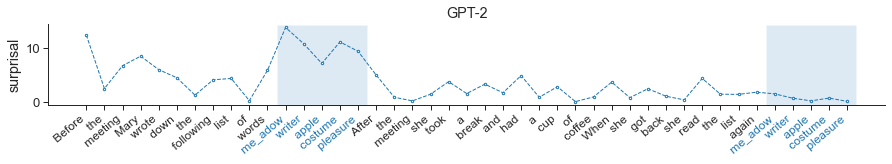

In [192]:
sns.set_style("ticks")
f, a = plot_example(x=x, y=y, markers=m, xlabels=l, ylabel="surprisal", fh=h, fw=w, title="GPT-2")

In [193]:
if savefigs:
    f.set_size_inches(w=w, h=h)
    print("Saving {}".format(os.path.join(savedir, "example_gpt2.pdf")))
    f.savefig(os.path.join(savedir, "example_gpt2.pdf"), transparent=True, dpi=300, bbox_inches="tight")
    f.savefig(os.path.join(savedir, "example_gpt2.png"), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\example_gpt2.pdf


### Select data (RNN example)

In [194]:
sel = (data_rnn.prompt_len==8) & \
      (data_rnn.list_len==5) & \
      (data_rnn.second_list=="repeat") & \
      (data_rnn.context=="intact") & \
      (data_rnn.list=="random") & \
      (data_rnn.model_id=="a-10") & \
      (data_rnn.stimid.isin([sentid]))
data = data_rnn.loc[sel].copy()

In [195]:
x = data.loc[data.stimid==sentid].reset_index().index.values
y = data.loc[data.stimid==sentid].surp.to_numpy()
m = data.loc[data.stimid==sentid].marker.to_numpy()
l = data.loc[data.stimid==sentid].token.to_numpy()

### Plot (RNN example)

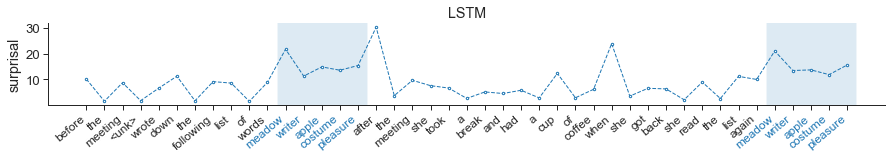

In [196]:
sns.set_style("ticks")
f, a = plot_example(x=x, y=y, markers=m, xlabels=l, ylabel="surprisal", fh=h, fw=w, title="LSTM")

In [197]:
if savefigs:
    f.set_size_inches(w=w, h=h)
    print("Saving {}".format(os.path.join(savedir, "example_rnn")))
    f.savefig(os.path.join(savedir, "example_rnn.pdf"), transparent=True, dpi=300, bbox_inches="tight")
    f.savefig(os.path.join(savedir, "example_rnn.png"), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\example_rnn


# Main figures

## Experiment 1 and 2: word order and semantic structure

### Create data structure

In [198]:
data = pd.concat([data_gpt, data_rnn], ignore_index=True)

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data.list = data.list.map(new_list_names)

new_second_list_names = {"control": "novel", "repeat": "repeated", "permute": "permuted"}
data.second_list = data.second_list.map(new_second_list_names)

In [199]:
context_len = 8
list_len = 10
context = "intact"

sel = (data.prompt_len==context_len) & \
      (data.list_len==list_len) & \
      (data.list.isin(["semantic", "arbitrary"])) & \
      (data.context==context) & \
      (data.model_id=="a-10") & \
      (data.marker.isin([2, 3])) & \
      (data.second_list.isin(["repeated", "permuted", "novel"])) &\
      (data.marker_pos_rel.isin(list(range(-4, 10))))

In [200]:
d = data.loc[sel].copy()

# name column manually
d.rename(columns={"list": "list structure", "second_list": "condition"}, inplace=True)

In [201]:
# common fig properties
w, h, w_disp, h_disp = 10, 1.8, 17, 3

In [202]:
# this fontsize should work
plt.rc("font", size=12)

In [203]:
new_second_list_names = {"novel": "Novel", "repeated": "Repeated", "permuted": "Permuted"}
d.condition = d.condition.map(new_second_list_names)

### Make plots (GPT-2)

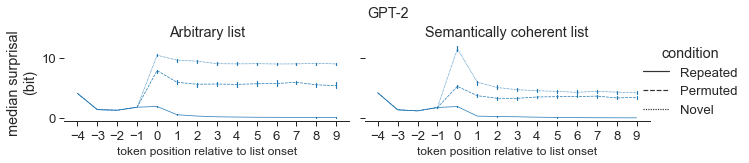

In [204]:
arch = "gpt-2"
p, ax, stat = make_plot(d.loc[d["model"] == arch], x="marker_pos_rel", style="condition", col="list structure", 
                        col_order=["arbitrary", "semantic"], style_order=["Repeated", "Permuted", "Novel"],
                        title="{}".format(arch), xticks=list(range(-4, 10)))

ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
ax[0].set_xlabel("token position relative to list onset", fontsize=12)
ax[1].set_xlabel("token position relative to list onset", fontsize=12)
p.fig.suptitle(arch.upper())
p.fig.set_size_inches(w=w, h=h)
p.fig.subplots_adjust(top=0.7)

In [205]:
if savefigs:
    p.fig.set_size_inches(w=w, h=h)
    p.fig.subplots_adjust(top=0.70)
    print("Saving {}".format(os.path.join(savedir, "word_order_{}".format(arch))))
    p.savefig(os.path.join(savedir, "word_order_{}.pdf".format(arch)), transparent=True, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "word_order_{}.png".format(arch)), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\word_order_gpt-2


### Export metrics (GPT-2)

In [206]:
basename = "time-course"
if savefigs:
    # create a column with string formateed and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"list structure": "list", "marker_pos_rel": "token position"}, inplace=True)
    tex = stat.loc[stat["token position"].isin(list(range(0, 10))), :]\
          .pivot(index=["token position"], columns=["list", "condition"], values="report_str")\
          .to_latex(bold_rows=True,
                    longtable=True,
                    caption="Surprisal values (GPT-2) per token position, list type and condition.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Writing \Users\karmeni1\project\lm-mem\tables\time-course_gpt-2_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\time-course_gpt-2_table.tex


In [207]:
# store stat variable for lower
stat["model"] = "gpt-2"
stat_gpt_0 = stat.loc[stat["token position"].isin(list(range(0, 1))), :]\
                 .pivot(index=["model", "list"], columns=["condition"], values="report_str")

### Plot (lstm)

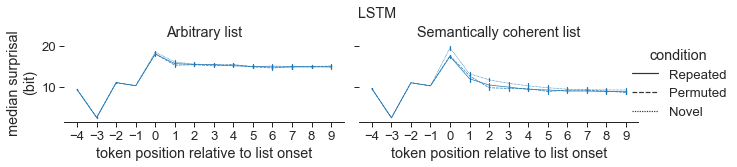

In [208]:
arch="lstm"
p, ax, stat = make_plot(d.loc[d["model"] == arch], x="marker_pos_rel", style="condition", col="list structure", 
                        col_order=["arbitrary", "semantic"], style_order=["Repeated", "Permuted", "Novel"],
                        title="{}".format(arch), xticks=list(range(-4, 10)))

ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
ax[0].set(xlabel="token position relative to list onset")
ax[1].set(xlabel="token position relative to list onset")
p.fig.suptitle(arch.upper())
p.fig.set_size_inches(w=w, h=h)
p.fig.subplots_adjust(top=0.7)

In [209]:
if savefigs:
    p.fig.set_size_inches(w=w, h=h)
    p.fig.subplots_adjust(top=0.70)
    print("Saving {}".format(os.path.join(savedir, "word_order_{}".format(arch))))
    p.savefig(os.path.join(savedir, "word_order_{}.pdf".format(arch)), transparent=True, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "word_order_{}.png".format(arch)), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\word_order_lstm


### Export metrics (lstm)

In [36]:
basename = "time-course"
if savefigs:
    # create a column with string formateed and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"list structure": "list", "marker_pos_rel": "token position"}, inplace=True)
    tex = stat.loc[stat["token position"].isin(list(range(0, 10))), :]\
              .pivot(index=["token position"], columns=["list", "condition"], values="report_str")\
              .to_latex(bold_rows=True,
                        longtable=True,
                        caption="Surprisal values (LSTM) per token position, list type and condition.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Writing \Users\karmeni1\project\lm-mem\tables\time-course_lstm_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\time-course_lstm_table.tex


### Create joint stat table for token-initial position

In [37]:
# store stat variable for lower
stat["model"] = "lstm"
stat_lstm_0 = stat.loc[stat["token position"].isin(list(range(0, 1))), :]\
                 .pivot(index=["model", "list"], columns=["condition"], values="report_str")

In [38]:
# joint s
stat0 = pd.concat([stat_gpt_0, stat_lstm_0])

In [39]:
fname = os.path.join(table_savedir, "time-course_token-initial_table.csv")
print("Writing {}".format(fname))
stat0.to_csv(fname)

stat0_tex = stat0.to_latex(bold_rows=True,
                      caption="Median surprisal ($N = 230$) values on the first position in word list. "
                              "Ranges represent 95\% confidence intervals "
                              "(bootstrap estimate obtained by sampling with replacement, $N^{sample} = 1000$)")

# now save as .tex file
fname = os.path.join(table_savedir, "time-course_token-initial_table.tex")
print("Writing {}".format(fname))
with open(fname, "w") as f:
    f.writelines(stat0_tex)

Writing \Users\karmeni1\project\lm-mem\tables\time-course_token-initial_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\time-course_token-initial_table.tex


## Experiment 3: effect of set size

In [40]:
data = None
data = pd.concat([data_gpt, data_rnn])

### Filter data

In [41]:
# select repeat condition and all list lengths
context_len = 8                       # take only short context for now
list_len = [3, 5, 7, 10]              # this is on the x-axis
context = "intact"                    # only intact context (no permute, etc.)
token_positions = list(range(1, 10))  # only select non-initial token positions

# we drop the first token
sel = (data.prompt_len==context_len) & \
      (data.list_len.isin(list_len)) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context==context) & \
      (data.model_id=="a-10") & \
      (data.marker.isin([1, 3])) & \
      (data.marker_pos_rel.isin(token_positions))

d = data.loc[sel].copy()

### Aggregate

In [42]:
# average separately per list_len, stimulus id (sentid), model (lstm or gpt2), marker (1 or 3), list (random, categorized) and second list (repeated, permuted or control)
units = ["list_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

### Compute metric

In [43]:
# apply relatvie change computation and apply to 
df_list = []
for model in ["gpt-2", "lstm"]:
    for length in [3, 5, 7, 10]:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                cols = ["x1", "x2", "x_del"]
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.list_len == length) & (dagg.second_list == condition) & (dagg.list == list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["list_len"] = length
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [44]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

# rename for ploting
new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
data.condition = data.condition.map(new_second_list_names)
data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})

### Plot (GPT-2)

In [45]:
plot_size=(4, 2)

N per group == 230


Text(0.5, 0.98, 'GPT-2')

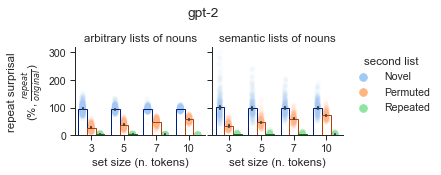

In [46]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
arch = "gpt-2"
p1, a, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                  x="list_len", y="x_perc", hue="condition", col="list", ylim=(None, None),
                  xlabel="set size (n. tokens)", ylabel="repeat surprisal\n(%, $\\frac{repeat}{original}$)", 
                  suptitle="{}".format(arch), 
                  legend=False, legend_out=False, legend_title="second list",
                  size_inches=plot_size)
p1.fig.subplots_adjust(top=0.7)
p.fig.suptitle(arch.upper())

### Point plot (GPT-2)

N per group == 230


Text(0.5, 0.98, 'GPT-2')

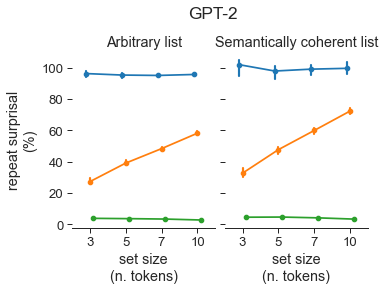

In [47]:
plot_size=(4.5,3.5)
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
arch = "gpt-2"
p1B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                  x="list_len", y="x_perc", hue="condition", col="list", ylim=(None, None),
                  xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(%)",
                  suptitle="{}".format(arch.upper()), scale=0.8,
                  legend=False, legend_out=False, custom_legend=False, legend_title="second list",
                  size_inches=plot_size)
p1B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
p.fig.suptitle(arch.upper())

### Save plot, export metrics (GPT-2)

In [48]:
basename = "set-size"
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}.pdf".format(basename, arch))))
    p1.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p1.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch))))
    p1B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p1B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    # create a column with string formateed and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.list_len = stat.list_len.astype(int)
    stat.sort_values(by="list_len")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"list_len": "set size"}, inplace=True)
    tex = stat.pivot(index=["list", "condition"], columns=["set size"], values="report_str")\
              .to_latex(bold_rows=True,
                        caption="GPT-2 word list surprisal as a function of set size. "
                                "We report the percentage of median surprisal on second lists relative to first list. " 
                                "Ranges are 95\% confidence intervals around the observed median " 
                                "(bootstrap estimate obtained by sampling with replacement ($N^{sample}=1000$). "
                                "The length of filler string is fixed at 8 tokens.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_gpt-2.pdf
Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_gpt-2_B.pdf
Writing \Users\karmeni1\project\lm-mem\tables\set-size_gpt-2_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\set-size_gpt-2.tex


### Plot (lstm)

N per group == 230


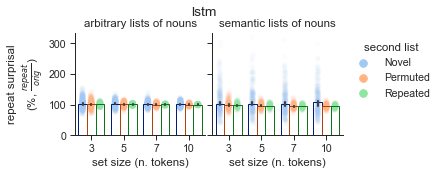

In [49]:
arch="lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
p2, _, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                  x="list_len", y="x_perc", hue="condition", col="list", ylim=(None, None),
                  xlabel="set size (n. tokens)", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                  suptitle="{}".format(arch), legend_title="second list",
                  size_inches=(4, 2))
p2.fig.subplots_adjust(top=0.8)

### Point plot (lstm)

N per group == 230


Text(0.5, 1.0, 'Semantically coherent list')

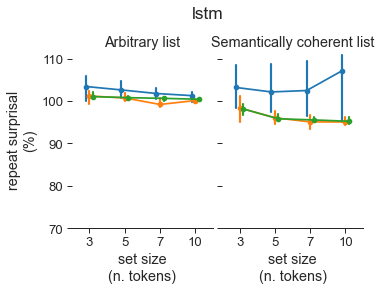

In [50]:
plot_size=(4.5, 3.5)
arch="lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p2B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                  x="list_len", y="x_perc", hue="condition", col="list", ylim=(70, None),
                  xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(%)",
                  scale=0.8,
                  suptitle="{}".format(arch), custom_legend=False, legend_title="second list",
                  size_inches=(4.5, 3.5))
p2B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")

### Save plot, export metrics (lstm)

In [51]:
basename = "set-size"
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}.pdf".format(basename, arch))))
    p2.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p2.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch))))
    p2B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p2B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    # create a column with string formateed and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.list_len = stat.list_len.astype(int)
    stat.sort_values(by="list_len")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"list_len": "set size"}, inplace=True)
    tex = stat.pivot(index=["list", "condition"], columns=["set size"], values="report_str")\
              .to_latex(bold_rows=True,
                        caption="LSTM word list surprisal as a function of set size. "
                                "We report the percentage of median surprisal on second lists relative to first list. " 
                                "Ranges are 95\% confidence intervals around the observed median " 
                                "(bootstrap estimate obtainedby sampling with replacement ($N^{sample}=1000$). "
                                "The length of filler string is fixed at 8 tokens.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_lstm.pdf
Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_lstm_B.pdf
Writing \Users\karmeni1\project\lm-mem\tables\set-size_lstm_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\set-size_lstm_table.tex


## Experiment 4: effect of context length

### Filter data

In [52]:
data = None
data = pd.concat([data_gpt, data_rnn])

In [53]:
# select repeat condition and all list lengths
context_len = [8, 100, 200, 400]
list_len = 10
context = "intact"
token_positions = list(range(1, 10))

# we drop the first token
sel = (data.prompt_len.isin(context_len)) & \
      (data.list_len.isin([list_len])) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context==context) & \
      (data.model_id=="a-10") & \
      (data.marker.isin([1, 3])) & \
      (data.marker_pos_rel.isin(token_positions))


In [54]:
d = data.loc[sel].copy()
d.prompt_len = d.prompt_len.astype(int)
# rename prompt length values to more meaningful ones
prompt_len_map = {
    8: 26,
    30: 47,
    100: 99,
    200: 194,
    400: 435,
}
d.prompt_len = d.prompt_len.map(prompt_len_map)

### Aggregate

In [55]:
# group by units/levels, then tage average per level combination
units = ["prompt_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

### Compute metric

In [56]:
# apply relative change computation and apply to 
df_list = []
for model in ["gpt-2", "lstm"]:
    for length in [26, 99, 194, 435]:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                cols = ["x1", "x2", "x_del"]
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.prompt_len == length) & (dagg.second_list == condition) & (dagg.list==list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["prompt_len"] = length
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [57]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

In [58]:
# rename for ploting
new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
data.condition = data.condition.map(new_second_list_names)
data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})

### Plot (GPT-2)

N per group == 230


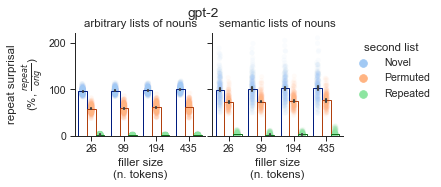

In [59]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plot_size = (4, 2)
p3, _, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                      x="prompt_len", y="x_perc", hue="condition", col="list", ylim=(None, None),
                      xlabel="filler size\n(n. tokens)", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                      suptitle="{}".format(arch), legend=False, legend_title="second list",
                      size_inches=plot_size)
p3.fig.subplots_adjust(top=0.8)

### Point plot (GPT-2)

N per group == 230


Text(0.5, 0.98, 'GPT-2')

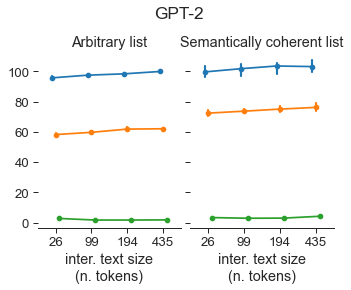

In [60]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plot_size = (4.5, 3.5)
p3B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                      x="prompt_len", y="x_perc", hue="condition", col="list", ylim=(None, None),
                      xlabel="inter. text size\n(n. tokens)", ylabel="", scale=0.8,
                      suptitle="{}".format(arch), legend=False, custom_legend=False, legend_title="second list",
                      size_inches=plot_size)
p3B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
p3B.fig.suptitle(arch.upper())

### Save plot, export metrics (GPT-2)

In [61]:
basename = "filler-size"
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}".format(basename, arch))))
    p3.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p3.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p3B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p3B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
        
    # create a column with string formateed and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.prompt_len = stat.prompt_len.astype(int)
    stat.sort_values(by="prompt_len")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"prompt_len": "filler size"}, inplace=True)
    tex = stat.pivot(index=["list", "condition"], columns=["filler size"], values="report_str")\
              .to_latex(bold_rows=True,
                        caption="GPT-2 word list surprisal per filler size. " + 
                                "Percent of median surprisal on second lists relative to first list. "
                                "Ranges are 95\% confidence intervals around the observed median "
                                "(bootstrap estimate). "
                                "Set size is fixed at 10 tokens.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-size_gpt-2
Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-size_gpt-2_B
Writing \Users\karmeni1\project\lm-mem\tables\filler-size_gpt-2_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\filler-size_gpt-2_table.tex


### Plot (lstm)

N per group == 230


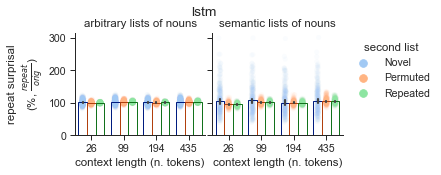

In [62]:
arch = "lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
p4, _, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                          x="prompt_len", y="x_perc", hue="condition", col="list",  ylim=(None, None),
                          xlabel="context length (n. tokens)", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                          suptitle="{}".format(arch), legend_title="second list",
                          size_inches=(4, 2))
p4.fig.subplots_adjust(top=0.8)

### Point plot (lstm)

N per group == 230


Text(0.5, 0.98, 'LSTM')

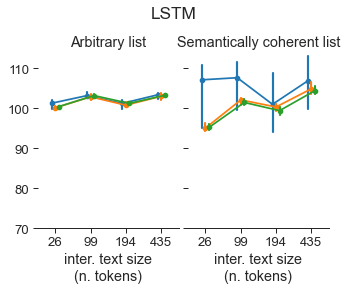

In [63]:
arch = "lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p4B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                          x="prompt_len", y="x_perc", hue="condition", col="list",  ylim=(70, None),
                          xlabel="inter. text size\n(n. tokens)", ylabel="", scale=0.8,
                          suptitle="{}".format(arch), custom_legend=False, legend_title="second list",
                          size_inches=(4.5, 3.5))
p4B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
p4B.fig.suptitle(arch.upper())

### Save plot, export metrics (lstm)

In [64]:
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}".format(basename, arch))))
    p4.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p4.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300,  bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p4B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p4B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300,  bbox_inches="tight")
    
    # create a column with string formated and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.prompt_len = stat.prompt_len.astype(int)
    stat.sort_values(by="prompt_len")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"prompt_len": "filler size"}, inplace=True)
    tex = stat.pivot(index=["list", "condition"], columns=["filler size"], values="report_str")\
              .to_latex(bold_rows=True,
                        caption="LSTM word list surprisal per filler size. "
                                "Percent of median surprisal on second lists relative to first list. " 
                                "Ranges are 95\% confidence intervals around the observed median " 
                                "(bootstrap estimate "
                                "Set size is fixed at 10 tokens.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-size_lstm
Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-size_lstm_B
Writing \Users\karmeni1\project\lm-mem\tables\filler-size_lstm_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\filler-size_lstm_table.tex


## Experiment 5: Effect of context structure

### Load data

In [65]:
gptlst = []
rnnlst = []
for sce in ["sce1", "sce2", "sce1rnd"]:
    rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_{}.csv".format(sce)), sep="\t", index_col=None)
    rnn.rename(columns={"word":"token"}, inplace=True)
    rnnlst.append(rnn)
    gptlst.append(pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(sce)), sep="\t", index_col=0))

data_gpt = pd.concat(gptlst)
data_rnn = pd.concat(rnnlst)
data_gpt["model"] = "gpt-2"
data_rnn["model"] = "lstm"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [66]:
data = None
data = pd.concat([data_gpt, data_rnn])

### Filter data

In [67]:
# select repeat condition and all list lengths
context_len = [400]
list_len = [10]
context = ["intact", 'scrambled', 'incongruent']
token_positions = list(range(1, 10)) # this excludes initial tokens at position 0

# we drop the first token
sel = (data.prompt_len.isin(context_len)) & \
      (data.list_len.isin(list_len)) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context.isin(context)) & \
      (data.model_id=="a-10") & \
      (data.marker.isin([1, 3])) & \
      (data.marker_pos_rel.isin(token_positions))

d = data.loc[sel].copy()

### Aggregate

In [68]:
units = ["context", "prompt_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

### Compute metric

In [69]:
df_list = []
for model in ["gpt-2", "lstm"]:
    for context in ["intact", 'scrambled', 'incongruent']:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.context == context) & (dagg.second_list == condition) & (dagg.list==list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["context"] = context
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [70]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

In [71]:
data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})
data.condition = data.condition.map({"control": "Novel", "repeat": "Repeated", "permute": "Permuted"})
data.context = data.context.map({"intact": "int.", "scrambled": "scr.", "incongruent": "inc."})

### Plot (GPT-2)

N per group == 230


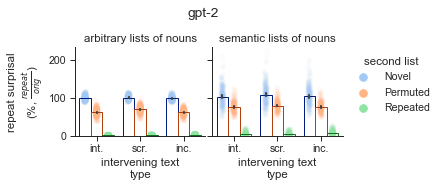

In [72]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plot_size = (4, 2)
p3, _, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                              x="context", y="x_perc", hue="condition", col="list", ylim=(None, None),
                              xlabel="intervening text\ntype", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                              suptitle="{}".format(arch), legend_title="second list",
                              size_inches=plot_size)
p3.fig.subplots_adjust(top=0.7)

### Plot point (GPT-2)

N per group == 230


Text(0.5, 0.98, 'GPT-2')

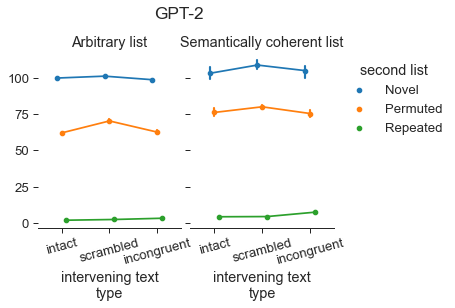

In [73]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p3B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                            x="context", y="x_perc", hue="condition", col="list", ylim=(None, None),
                            xlabel="intervening text\ntype", ylabel="", join=True, scale=0.8,
                            suptitle="{}".format(arch), custom_legend=True, legend_title="second list",
                            size_inches=(4.5, 3.5))
p3B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
ax[0].set_xticklabels(labels=["intact", "scrambled", "incongruent"], rotation=15)
ax[1].set_xticklabels(labels=["intact", "scrambled", "incongruent"], rotation=15)
p3B.fig.suptitle(arch.upper())

### Save plot, export metrics (GPT-2)

In [74]:
basename = "filler-type"
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}".format(basename, arch))))
    p3.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p3.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p3B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p3B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    # create a column with string formated and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    tex = stat.pivot(index=["list", "condition"], columns=["context"], values="report_str")\
              .reindex(columns = ["intact", "incongruent", "scrambled"])\
              .to_latex(bold_rows=True,
                       caption="GPT-2 word list surprisal by the content of intervening context "
                               "Median surprisal on second lists as percentage relative to first list surprisal. "
                               "Ranges are 95\% confidence intervals around the observed median " 
                               "(bootstrap estimate). "
                               "Set size and filler size are fixed at 10 and ~400 tokens, respectively.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-type_gpt-2
Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-type_gpt-2_B
Writing \Users\karmeni1\project\lm-mem\tables\filler-type_gpt-2_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\filler-type_gpt-2_table.tex


### Plot (lstm)

N per group == 230


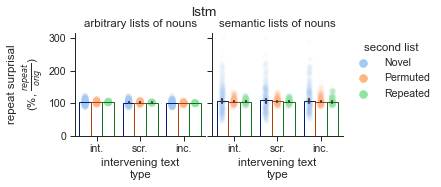

In [75]:
arch="lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plot_size = (4, 2)
p4, _, stat = make_bar_plot(data_frame=data.loc[data.model==arch], 
                          x="context", y="x_perc", hue="condition", col="list", ylim=(None, None),
                          xlabel="intervening text\ntype", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                          suptitle="{}".format(arch), legend_title="second list",
                          size_inches=plot_size)
p4.fig.subplots_adjust(top=0.8)

### Point plot (lstm)

N per group == 230


Text(0.5, 0.98, 'LSTM')

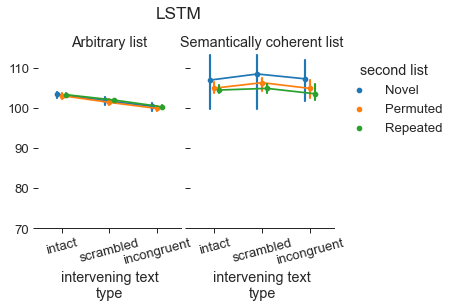

In [76]:
arch="lstm"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p4B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                      x="context", y="x_perc", hue="condition", col="list", ylim=(70, None),
                      xlabel="intervening text\ntype", ylabel="", scale=0.8,
                      suptitle="{}".format(arch), legend=False, custom_legend=True, legend_title="second list",
                      size_inches=(4.5, 3.5))
p4B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
ax[0].set_xticklabels(labels=["intact", "scrambled", "incongruent"], rotation=15)
ax[1].set_xticklabels(labels=["intact", "scrambled", "incongruent"], rotation=15)
p4B.fig.suptitle(arch.upper())

### Save plot, export metrics (lstm)

In [77]:
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}".format(basename, arch))))
    p4.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p4.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300,  bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p4B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p4B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300,  bbox_inches="tight")
    
    # create a column with string formated and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.sort_values(by="context")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    tex = stat.pivot(index=["list", "condition"], columns=["context"], values="report_str")\
              .reindex(columns = ["intact", "incongruent", "scrambled"])\
              .to_latex(bold_rows=True,
                        caption="LSTM  word list surprisal by the content of intervening context " 
                                "We report the percent of median surprisal on second lists relative to first list "
                                "Ranges are 95\% confidence intervals around the observed median " 
                                "(bootstrap estimate). "
                                "Set size and filler size are fixed at 10 and \tilde400 tokens, respectively.")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-type_lstm
Saving \Users\karmeni1\project\lm-mem\fig\cshift\filler-type_lstm_B
Writing \Users\karmeni1\project\lm-mem\tables\filler-type_lstm_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\filler-type_lstm_table.tex


## Experiment 6: effect of short context

### Filter data

In [78]:
rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce3.csv".format(sce)), sep="\t", index_col=None)
rnn.rename(columns={"word":"token"}, inplace=True)

In [79]:
data = None
data = rnn
data["model"] = "lstm"

In [80]:
# select repeat condition and all list lengths
context_len = 8
list_len = [3, 5, 7, 10]
context = "short"

# we drop the first token
sel = (data.prompt_len==context_len) & \
      (data.list_len.isin(list_len)) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context==context) & \
      (data.model_id=="a-10") & \
      (data.marker.isin([0, 1, 2, 3]))

d = data.loc[sel].copy()

### Plot a time course

In [81]:
sent_id=120
second_list="repeat"
list_type="random"
sel = (d.stimid==sent_id) & (d.second_list==second_list) & (d.list_len==10) & (d.list==list_type)
x = d.loc[sel].reset_index().index.values
y = d.loc[sel].surp.to_numpy()
m = d.loc[sel].marker.to_numpy()
l = d.loc[sel].token.to_numpy()

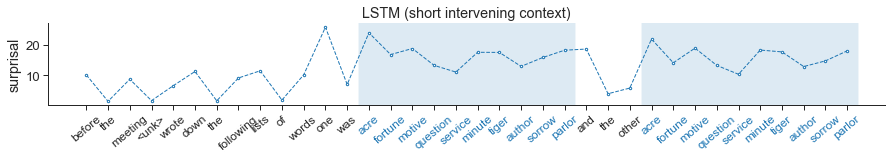

In [82]:
f, a = plt.subplots(figsize=(15, 1.5))
a.plot(x, y, marker=".", markerfacecolor="white", linestyle="--", linewidth=1)


x_rect = np.where(l==l[m==3][0])[0]
y_rect = a.get_ylim()[0]

for i, xloc in enumerate(x_rect):             
    a.add_patch(Rectangle(xy=(xloc-0.5, y_rect), width=len(l[m==1]), height=a.get_ylim()[-1]+0.5, 
                           edgecolor=None, facecolor="tab:blue", alpha=0.15))

a.set_xticks(x);
a.set_xticklabels(l, rotation=40, fontsize=12, ha="center");

bluewords = d.loc[sel].marker.isin([1, 3]).to_numpy()

[t.set_color("tab:blue") for i, t in enumerate(a.xaxis.get_ticklabels()) if bluewords[i]]

a.spines["top"].set_visible(False)
a.spines["right"].set_visible(False)

a.set(ylabel="surprisal", title="LSTM (short intervening context)");

In [83]:
if savefigs:
    f.set_size_inches(w, h)
    f.savefig(os.path.join(savedir, "example_short_context_{}_nouns.pdf".format(list_type)), transparent=True, bbox_inches="tight")
    f.savefig(os.path.join(savedir, "example_short_context_{}_nouns.png".format(list_type)), dpi=300, bbox_inches="tight")

### Aggregate

In [84]:
units = ["list_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

### Compute metric

In [85]:
# apply relative change computation and apply to 
df_list = []
for model in ["lstm"]:
    for length in [3, 5, 7, 10]:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.list_len == length) & (dagg.second_list == condition) & (dagg.list==list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()         # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["list_len"] = length
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [86]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

In [87]:
data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})
data.condition = data.condition.map({"control": "Novel", "repeat": "Repeated", "permute": "Permuted"})

### Plot (lstm)

N per group == 230


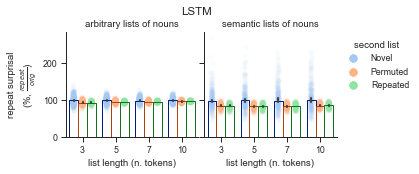

In [88]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1)
p5, _, stat = make_bar_plot(data_frame=data, 
                              x="list_len", y="x_perc", hue="condition", col="list",
                              xlabel="list length (n. tokens)", ylabel="repeat surprisal\n(%, $\\frac{repeat}{orig}$)", 
                              suptitle="LSTM", legend_title="second list",
                              size_inches=(4, 2))
p5.fig.subplots_adjust(top=0.8)

### Plot point (lstm)

N per group == 230


Text(0.5, 1.0, 'Semantically coherent list')

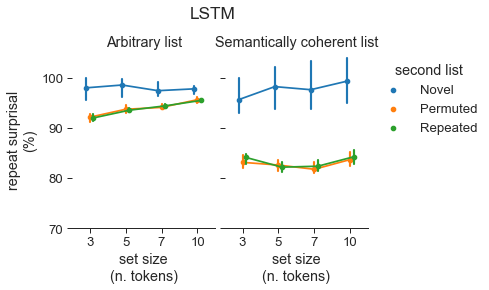

In [89]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p5B, ax, _ = make_point_plot(data_frame=data, 
                              x="list_len", y="x_perc", hue="condition", col="list", ylim=(70, None),
                              xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(%)", scale=0.8, 
                              suptitle="LSTM", legend_title="second list",
                              size_inches=(4.5, 3.5))
p5B.fig.subplots_adjust(top=0.8)
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")

### Save plot, export metric (lstm)

In [90]:
basename = "short-filler"
arch = "lstm"
if savefigs:
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}".format(basename, arch))))
    p5.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p5.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p5B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p5B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
        
    # create a column with string formated and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)
    stat.list_len = stat.list_len.astype(int)
    stat.sort_values(by="list_len")
    
    # save the original .csv
    fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
    print("Writing {}".format(fname))
    stat.to_csv(fname)
    
    # save for latex
    stat.rename(columns={"list_len": "set size"}, inplace=True)
    tex = stat.pivot(index=["list", "condition"], columns=["set size"], values="report_str")\
              .to_latex(bold_rows=True,
                        caption="LSTM results for short intervening context (4 tokens)."
                                "We report the percent of median surprisal on second lists relative to first list. "
                                "Ranges are 95\% confidence intervals around the observed median " 
                                "(bootstrap estimate).")
    
    # now save as .tex file
    fname = os.path.join(table_savedir, "{}_{}_table.tex".format(basename, arch))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\short-filler_lstm
Saving \Users\karmeni1\project\lm-mem\fig\cshift\short-filler_lstm_B
Writing \Users\karmeni1\project\lm-mem\tables\short-filler_lstm_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\short-filler_lstm_table.tex


# Random GPT-2

In [153]:
model_id = "r-10"
sce = "sce1"
gptrnd = pd.read_csv(os.path.join(data_dir, "output_gpt2_{}_{}.csv".format(model_id, sce)), sep="\t", index_col=None)

In [154]:
# pick a random sentence
rng = np.random.RandomState(12345)
sentid = rng.randint(low=1, high=230)

## Filter data

In [158]:
sel = (gptrnd.prompt_len==8) & \
      (gptrnd.list_len==10) & \
      (gptrnd.second_list=="repeat") & \
      (gptrnd.context=="intact") & \
      (gptrnd.list.isin(["random"])) & \
      (gptrnd.stimid.isin([sentid])) & \
      (gptrnd.model_id==model_id)

data = gptrnd.loc[sel].copy()

In [159]:
x = data.loc[data.stimid==sentid].reset_index().index.values
y = data.loc[data.stimid==sentid].surp.to_numpy()
m = data.loc[data.stimid==sentid].marker.to_numpy()
l = data.loc[data.stimid==sentid].token.to_numpy()

## Plot example trial

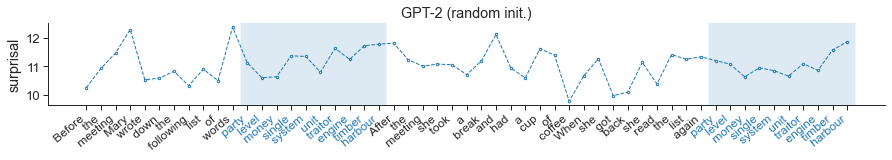

In [160]:
w, h = 1.5, 15
sns.set_style("ticks")
f, a = plot_example(x=x, y=y, markers=m, xlabels=l, ylabel="surprisal", fh=1.5, fw=15, title="GPT-2 (random init.)")

In [161]:
if savefigs:
    f.set_size_inches(w=w, h=h)
    print("Saving {}".format(os.path.join(savedir, "example_gpt2_r-10")))
    f.savefig(os.path.join(savedir, "example_gpt2_r-10.pdf"), transparent=True, dpi=300, bbox_inches="tight")
    f.savefig(os.path.join(savedir, "example_gpt2-r-10.png"), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\example_gpt2_r-10


## Filter data for main plot

In [162]:
data = None
data = gptrnd
data["model"] = "gpt-2"

In [163]:
# select repeat condition and all list lengths
context_len = 8                       # take only short context for now
list_len = [3, 5, 7, 10]              # this is on the x-axis
context = "intact"                    # only intact context (no permute, etc.)
token_positions = list(range(1, 10))  # only select non-initial token positions

# we drop the first token
sel = (data.prompt_len==context_len) & \
      (data.list_len.isin(list_len)) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context==context) & \
      (data.model_id=="r-10") & \
      (data.marker.isin([1, 3])) & \
      (data.marker_pos_rel.isin(token_positions))

d = data.loc[sel].copy()

## Aggregate

In [164]:
# average separately per:
# list_len, stimulus id (sentid), model (lstm or gpt2), marker (1 or 3), list (random, categorized) and second list (repeated, permuted or control)
units = ["list_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

## Compute metric

In [165]:
# apply relatvie change computation and apply to 
df_list = []
for model in ["gpt-2"]:
    for length in [3, 5, 7, 10]:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                cols = ["x1", "x2", "x_del"]
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.list_len == length) & (dagg.second_list == condition) & (dagg.list == list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["list_len"] = length
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [166]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})
data.condition = data.condition.map({"control": "Novel", "repeat": "Repeated", "permute": "Permuted"})

## Point plot (random gpt-2)

N per group == 230


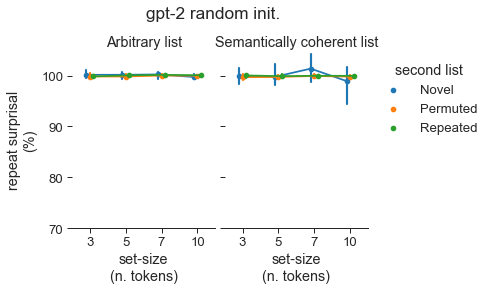

In [167]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p1B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                           x="list_len", y="x_perc", hue="condition", col="list", ylim=(70, None),
                           xlabel="set-size\n(n. tokens)", ylabel="repeat surprisal\n(%)", 
                           scale=0.8,
                           suptitle="{} {}".format(arch, model_id).replace(model_id, "random init."), legend_title="second list",
                           size_inches=(4.5, 3.5))
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
p1B.fig.subplots_adjust(top=0.8)

## Export metric

In [168]:
basename = "set-size"
arch = "gpt2_r-10"
hasstat = False
if savefigs:
    
    #p1.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    #p1.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p1B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p1B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    if hasstat:
        # create a column with string formateed and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)
        stat.list_len = stat.list_len.astype(int)
        stat.sort_values(by="list_len")

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list_len": "set size"}, inplace=True)
        tex = stat.pivot(index=["list", "condition"], columns=["set size"], values="report_str")\
                  .to_latex(bold_rows=True,
                            caption="GPT-2 (random initialization) word list surprisal per set size. "
                                    "We report the percentage of mean surprisal on second lists relative to first list. " 
                                    "Ranges are 95\% confidence intervals around the observed mean " 
                                    "(bootstrap estimate). "
                                    "The length of filler string is fixed at 8 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}.tex".format(basename, arch))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_gpt2_r-10_B


# Random attention GPT-2

In [169]:
model_id = "r-20"
gptrnd = pd.read_csv(os.path.join(data_dir, "output_gpt2_{}_sce1.csv".format(model_id)), sep="\t", index_col=None)

In [170]:
# pick a random sentence
rng = np.random.RandomState(12345)
sentid = rng.randint(low=1, high=230)

## Filter data

In [171]:
sel = (gptrnd.prompt_len==8) & \
      (gptrnd.list_len==10) & \
      (gptrnd.second_list=="repeat") & \
      (gptrnd.context=="intact") & \
      (gptrnd.list=="random") & \
      (gptrnd.stimid.isin([sentid])) & \
      (gptrnd.model_id==model_id)
data = gptrnd.loc[sel].copy()

In [172]:
x = data.loc[data.stimid==sentid].reset_index().index.values
y = data.loc[data.stimid==sentid].surp.to_numpy()
m = data.loc[data.stimid==sentid].marker.to_numpy()
l = data.loc[data.stimid==sentid].token.to_numpy()

## Plot example trial

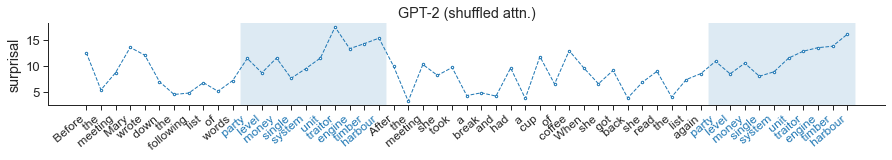

In [173]:
sns.set_style("ticks")
h, w = 1.5, 15
f, a = plot_example(x=x, y=y, markers=m, xlabels=l, ylabel="surprisal", fh=h, fw=w, title="GPT-2 (shuffled attn.)")

In [174]:
if savefigs:
    
    f.set_size_inches(w=w, h=h)
    
    print("Saving {}".format(os.path.join(savedir, "example_gpt2-{}.pdf".format(model_id))))
    f.savefig(os.path.join(savedir, "example_gpt2-{}.pdf".format(model_id)), transparent=True, bbox_inches="tight")
    f.savefig(os.path.join(savedir, "example_gpt2-{}.png".format(model_id)), dpi=300, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\example_gpt2-r-20.pdf


## Filter data for main plot

In [175]:
data = None
data = gptrnd
data["model"] = "gpt-2"

In [176]:
# select repeat condition and all list lengths
context_len = 8                       # take only short context for now
list_len = [3, 5, 7, 10]              # this is on the x-axis
context = "intact"                    # only intact context (no permute, etc.)
token_positions = list(range(1, 10))  # only select non-initial token positions

# we drop the first token
sel = (data.prompt_len==context_len) & \
      (data.list_len.isin(list_len)) & \
      (data.second_list.isin(["repeat", "permute", "control"])) & \
      (data.list.isin(["random", "categorized"])) & \
      (data.context==context) & \
      (data.model_id==model_id) & \
      (data.marker.isin([1, 3])) & \
      (data.marker_pos_rel.isin(token_positions))

d = data.loc[sel].copy()

## Aggregate

In [177]:
# average separately per list_len, stimulus id (sentid), model (lstm or gpt2), marker (1 or 3), list (random, categorized) and second list (repeated, permuted or control)
units = ["list_len", "stimid", "model", "marker", "list", "second_list"]
dagg = d.groupby(units).agg({"surp": ["mean", "std"], "token": list}).reset_index()
dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]

## Compute metric

In [178]:
# apply relatvie change computation and apply to 
df_list = []
for model in ["gpt-2"]:
    for length in [3, 5, 7, 10]:
        for condition in ["repeat", "permute", "control"]:
            for list_type in ["categorized", "random"]:
            
                cols = ["x1", "x2", "x_del"]
                df = pd.DataFrame(columns=cols)

                select = (dagg.model == model) & (dagg.list_len == length) & (dagg.second_list == condition) & (dagg.list == list_type)
                tmp = dagg.loc[select].copy()

                x1=tmp.loc[tmp.marker==1].surp_mean.to_numpy()           # average per sentence surprisal on first list
                x2=tmp.loc[tmp.marker==3].surp_mean.to_numpy()           # average per sentence surprisal on second list
                labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)

                df["x1"] = x1
                df["x2"] = x2
                df["x_del"] = x_del
                df["x_perc"] = x_perc
                df["model"] = model
                df["list_len"] = length
                df["list"] = list_type
                df["condition"] = condition

                df_list.append(df)

In [179]:
# concatenate relative scores
data = None
data = pd.concat(df_list)

data.list = data.list.map({"categorized": "semantic", "random": "arbitrary"})
data.condition = data.condition.map({"control": "Novel", "repeat": "Repeated", "permute": "Permuted"})

## Point plot (shuff. attn. gpt-2)

N per group == 230


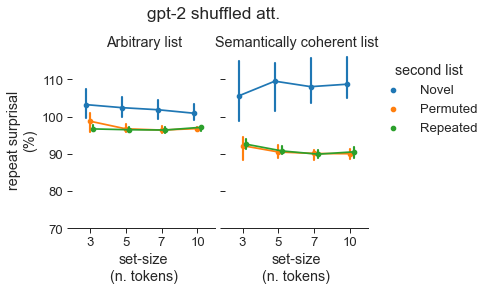

In [180]:
arch="gpt-2"
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
p2B, ax, _ = make_point_plot(data_frame=data.loc[data.model==arch], 
                           x="list_len", y="x_perc", hue="condition", col="list", ylim=(70, None),
                           xlabel="set-size\n(n. tokens)", ylabel="repeat surprisal\n(%)", 
                           scale=0.8,
                           suptitle="{} {}".format(arch, model_id).replace(model_id, "shuffled att."), legend_title="second list",
                           size_inches=(4.5, 3.5))
ax[0].set_title("Arbitrary list")
ax[1].set_title("Semantically coherent list")
p2B.fig.subplots_adjust(top=0.8)

In [181]:
basename = "set-size"
arch = "gpt2_r-20"
hasstat = False
if savefigs:
    
    #p1.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    #p1.savefig(os.path.join(savedir, "{}_{}.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    print("Saving {}".format(os.path.join(savedir, "{}_{}_B".format(basename, arch))))
    p2B.savefig(os.path.join(savedir, "{}_{}_B.pdf".format(basename, arch)), transparent=True, bbox_inches="tight")
    p2B.savefig(os.path.join(savedir, "{}_{}_B.png".format(basename, arch)), dpi=300, bbox_inches="tight")
    
    if hasstat:
        # create a column with string formateed and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)
        stat.list_len = stat.list_len.astype(int)
        stat.sort_values(by="list_len")

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_table.csv".format(basename, arch))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list_len": "set size"}, inplace=True)
        tex = stat.pivot(index=["list", "condition"], columns=["set size"], values="report_str")\
                  .to_latex(bold_rows=True,
                            caption="GPT-2 (shuffled attention) word list surprisal per set size. "
                                    "We report the percentage of median surprisal on second lists relative to first list. " 
                                    "Ranges are 95\% confidence intervals around the observed mean " 
                                    "(bootstrap estimate). "
                                    "The length of filler string is fixed at 8 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}.tex".format(basename, arch))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

Saving \Users\karmeni1\project\lm-mem\fig\cshift\set-size_gpt2_r-20_B


# Experiment 6: n-gram experiment

In [117]:
data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce1.csv"), sep="\t", index_col=None)
data_rnn.rename(columns={"word":"token"}, inplace=True)

data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_sce1.csv"), sep="\t", index_col=0)

data_gpt["model"] = "gpt-2"
data_rnn["model"] = "lstm"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [118]:
# select appropriate rows
selection = (data_rnn.list.isin(["ngram-random", "ngram-categorized"])) & (data_rnn.marker.isin([1, 2])) & (data_rnn.model_id=="a-10")
rnn = data_rnn.loc[selection].copy()

drop = ["prompt_len", "list_len", "context", "second_list"]
rnn.drop(columns=drop + ["hs", "dHs"], inplace=True)

In [119]:
selection = (data_gpt.list.isin(["ngram-random", "ngram-categorized"])) & (data_gpt.marker.isin([1, 2])) & (data_gpt.model_id=="a-10")
gpt = data_gpt.loc[selection].copy()
gpt.drop(columns=drop, inplace=True)

In [120]:
# <subtok_markers> keeps track of markers, crename columns to make it consistent downstream
newcolnames = {"subtok_markers": "marker", "marker": "marker_old"}
gpt.rename(columns=newcolnames, inplace=True)

In [121]:
newtypes = {"ngram_len": int, "dist_len": int, "stimid": int}
gpt = gpt.astype(newtypes)
rnn = rnn.astype(newtypes)

### Count n-gram positions (for x-axis)

In [122]:
# let's create a ngram position counter
def add_ngram_columns(data_frame):
    
    df= None
    df = data_frame.copy()
    
    col = []
    col2 = []
    
    for list_type in df.list.unique():
    
        for ngram_len in df.ngram_len.unique():

            for dist_len in df.dist_len.unique():

                for stimid in df.stimid.unique():

                    sel = (df.list == list_type) & (df.ngram_len == ngram_len) & (df.dist_len == dist_len) & (df.stimid == stimid)
                    tmp = df.loc[sel]

                    repetitions = 5
                    listlen = len(tmp)
                    ngram = int(tmp.ngram_len.iloc[0])
                    dist = int(tmp.dist_len.iloc[0])

                    ngram_pos = np.repeat(np.arange(0, repetitions), ngram+dist) + 1
                    token_pos = np.tile(np.arange(0, ngram+dist), repetitions) + 1
                    if dist != 0:
                        ngram_pos = ngram_pos[:-dist]
                        token_pos = token_pos[:-dist]

                    col.append(ngram_pos) # index ngram position withing sequence
                    col2.append(token_pos)  # index tokens

    df["ngram_pos"] = np.concatenate(col)
    df["token_pos"] = np.concatenate(col2)
    
    return df

In [123]:
rnn = add_ngram_columns(rnn)

In [124]:
gpt = add_ngram_columns(gpt)

### Data structure check

In [125]:
stimid = 150
n_ngram = [2, 3]
n_distractor = [0, 3]
for n1 in n_ngram:
    for n2 in n_distractor:
        
        sel = ((rnn.ngram_len==n1) & (rnn.dist_len == n2) & (rnn.stimid==stimid))
        print("token:" + " ".join(rnn.loc[sel].token.tolist()))
        print("marker:" + " ".join(rnn.loc[sel].marker.astype(str).tolist()))
        print("ngram pos:" + " ".join(rnn.loc[sel].ngram_pos.astype(str).tolist()))
        print("token pos:" + " ".join(rnn.loc[sel].token_pos.astype(str).tolist()))

token:shirt socks shirt socks shirt socks shirt socks shirt socks island theory island theory island theory island theory island theory
marker:1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
ngram pos:1 1 2 2 3 3 4 4 5 5 1 1 2 2 3 3 4 4 5 5
token pos:1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
token:shirt socks chapel record railway shirt socks frontier diamond velvet shirt socks hunter puzzle virtue shirt socks pasture speaker status shirt socks island theory chapel record railway island theory frontier diamond velvet island theory hunter puzzle virtue island theory pasture speaker status island theory
marker:1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1 1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 1 1
ngram pos:1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5
token pos:1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2
token:shirt socks pants shirt socks pants shirt socks pants shirt socks pants shirt socks pants island theory 

### Plot some trial trime courses for n-grams 

In [126]:
def plot_trial(data, sentence_id, ngram_len, dist_len, ylabel, title=None, size_inches=(10, 2)):
    
    sel = (data.stimid == sentence_id) & (data.ngram_len == ngram_len) & (data.dist_len == dist_len)
    
    x = data.loc[sel].reset_index().index.values
    y = data.loc[sel].surp.to_numpy()
    l = data.loc[sel].token.to_numpy()
    groups = data.loc[sel].ngram_pos
    markers = data.loc[sel].marker
    
    last_tok = l[(markers == 1) & (groups == 1)].tolist()[-1]
    
    f, ax = plt.subplots(figsize=size_inches)
    
    ax.plot(x, y, marker=".", markerfacecolor="white", linestyle="--", linewidth=1)
    
    n_rect = groups[markers == 1].unique()
    x_rect = np.where(l==l[0])[0]
    y_rect = ax.get_ylim()[0]
    
    for j, rect in enumerate(n_rect):
        ax.add_patch(Rectangle(xy=(x_rect[j]-0.5, y_rect), width=ngram_len, height=ax.get_ylim()[-1], 
                               edgecolor=None, facecolor="tab:blue", alpha=0.15))
    
    #ax.vlines(x=np.where(l==l[0]), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[-1], color="r", linestyle="--", linewidth=1)
    #ax.vlines(x=np.where(l==last_tok), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[-1], color="r", linestyle="--", linewidth=1)
    
    ax.set_xticks(x);
    #ax.get_xticks().set_visible(True)
    ax.set_xticklabels(l, rotation=40, fontsize=10, ha="center");

    highlightwords = (markers == 2).to_numpy()

    [t.set_color("tab:gray") for i, t in enumerate(ax.xaxis.get_ticklabels()) if highlightwords[i]]

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set(ylabel=ylabel, title=title);
    
    return f, ax

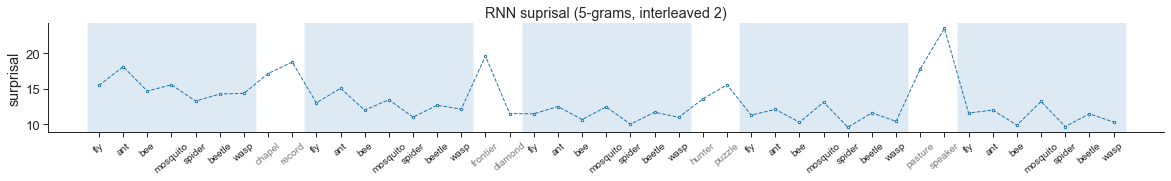

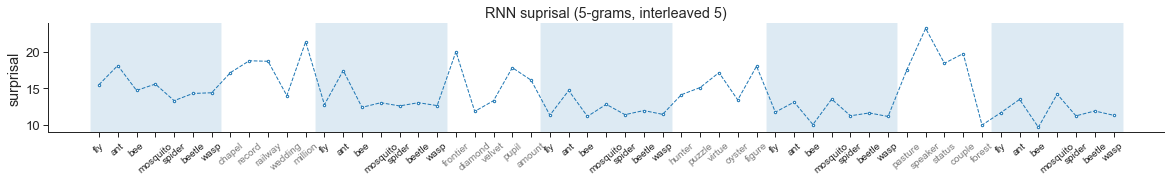

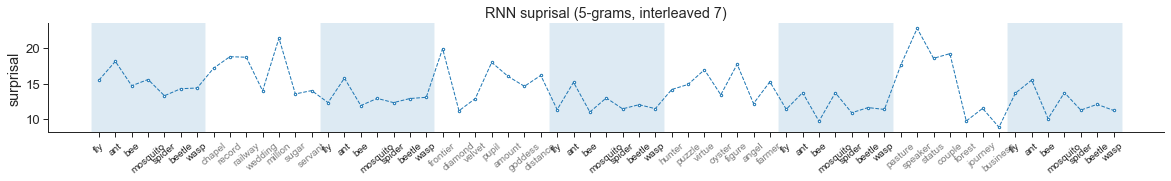

In [127]:
data=None
data=rnn
sentid=200
list_type="ngram-categorized"
w, h = 20, 2
f1, a1 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=2, ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 2)", size_inches=(w, h))
f2, a2 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=5, ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 5)", size_inches=(w, h))
f3, a3 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=7, ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 7)", size_inches=(w, h))

In [128]:
if savefigs:
    
    for i, fig in enumerate((f1, f2, f3)):
        fig.set_size_inches(w, h)
        print("Saving 5-gram_example_RNN_{}_{}.pdf".format(list_type, i))
        fig.savefig(os.path.join(savedir, "5-gram_example_RNN_{}_{}.pdf".format(list_type, i)), transparent=True, bbox_inches="tight")
        fig.savefig(os.path.join(savedir, "5-gram_example_RNN_{}_{}.png".format(list_type, i)), dpi=300, bbox_inches="tight")

Saving 5-gram_example_RNN_ngram-categorized_0.pdf
Saving 5-gram_example_RNN_ngram-categorized_1.pdf
Saving 5-gram_example_RNN_ngram-categorized_2.pdf


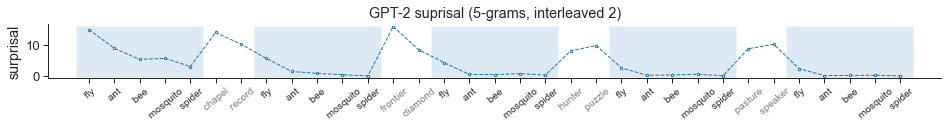

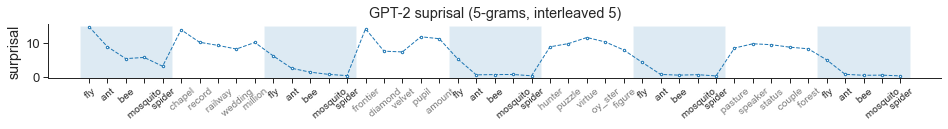

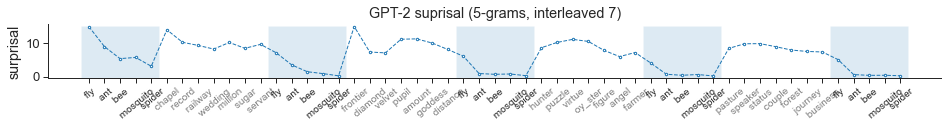

In [129]:
data=None
data=gpt
w, h = 16, 1
f1, a1 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=2, ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 2)", size_inches=(16, 1))
f2, a2 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=5, ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 5)", size_inches=(16, 1))
f3, a3 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=7, ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 7)", size_inches=(16, 1))

In [130]:
if savefigs:
    
    for i, fig in enumerate((f1, f2, f3)):
        fig.set_size_inches(w, h)
        fig.savefig(os.path.join(savedir, "5-gram_example_GPT-2_arbitrary_nouns_{}.pdf".format(i)), transparent=True, bbox_inches="tight")
        fig.savefig(os.path.join(savedir, "5-gram_example_GPT-2_arbitrary_nouns_{}.png".format(i)), dpi=300, bbox_inches="tight")

### Aggregate lstm

In [131]:
# select marker == these are target nouns for the desired list
rnnsel = rnn.loc[rnn.marker == 1].copy()

rnn_agg = rnnsel.groupby(["model", "list", "ngram_len", "dist_len", "ngram_pos", "stimid"]) \
               .agg({"surp": ["mean", "std"], "token": list}) \
               .reset_index()
rnn_agg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in rnn_agg.columns.values]

### Plot (lstm, arbitrary lists nouns)

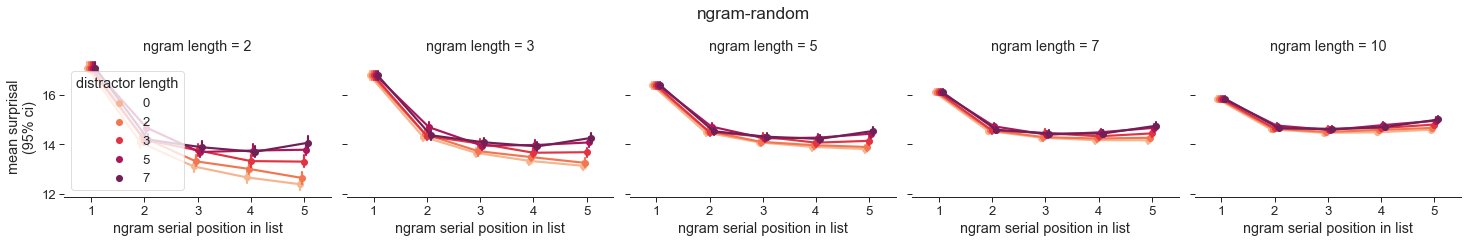

In [132]:
selected_list = "ngram-random"
p = sns.catplot(data=rnn_agg.loc[rnn_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [133]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\rnn_ngram-random


### Plot (lstm, semantic lists)

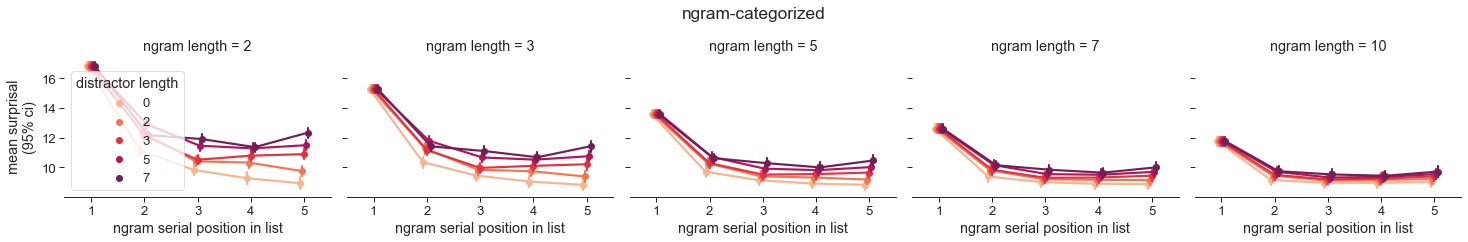

In [134]:
selected_list = "ngram-categorized"
p2 = sns.catplot(data=rnn_agg.loc[rnn_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"))
p2.fig.set_size_inches(20, 3)  
p2.fig.subplots_adjust(top=0.75)
p2.fig.suptitle(selected_list)
p2.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p2._legend.set_title("distractor length")
p2.set_titles("ngram length = {col_name}")
p2.despine(left=True);

In [135]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}.png".format(selected_list)))
    p2.savefig(os.path.join(savedir, "rnn_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p2.savefig(os.path.join(savedir, "rnn_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\rnn_ngram-categorized.png


### Aggregate GPT-2

In [136]:
gptsel = gpt.loc[gpt.marker == 1].copy()
gpt_agg = gptsel.groupby(["model", "list", "ngram_len", "dist_len", "ngram_pos", "stimid"]) \
               .agg({"surp": ["mean", "std"], "token": list}) \
               .reset_index()
gpt_agg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in gpt_agg.columns.values]

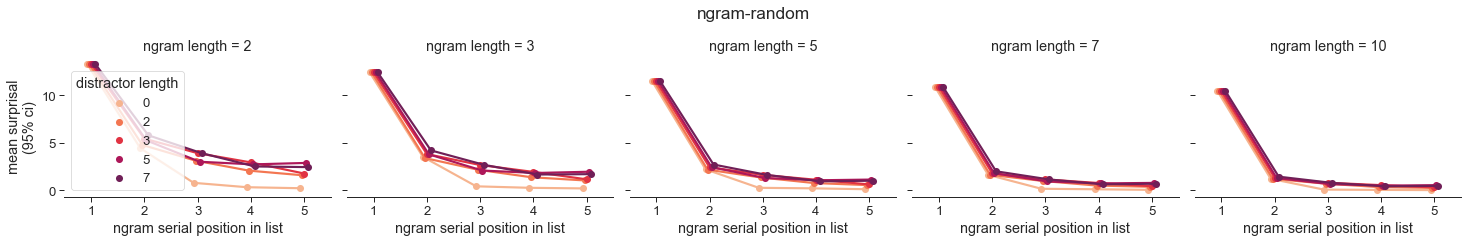

In [137]:
selected_list="ngram-random"
p = sns.catplot(data=gpt_agg[gpt_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"), )
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [138]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\gpt_ngram-random


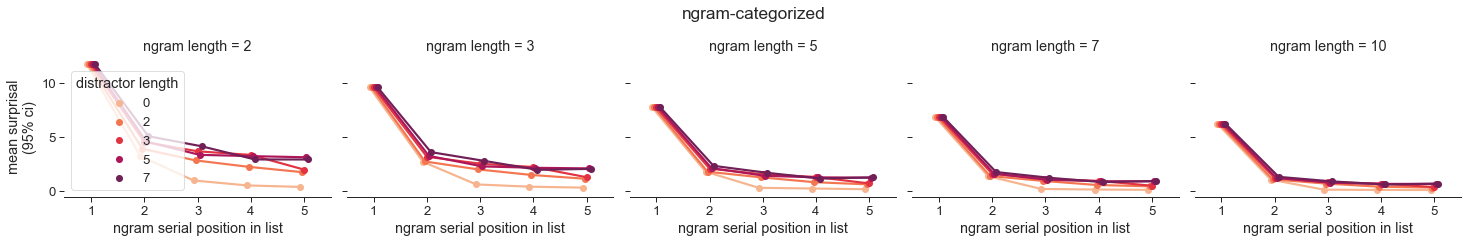

In [139]:
selected_list="ngram-categorized"
p = sns.catplot(data=gpt_agg[gpt_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"), )
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [140]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\gpt_ngram-categorized


### Per token position within ngram

In [141]:
gpt["model"] = "gpt-2"
rnn["model"] = "rnn"

### Plot per token position (lstm)

In [142]:
data = rnn.loc[rnn.marker==1]  # 1 == ngram, 2 == distractor
selected_list="ngram-random"

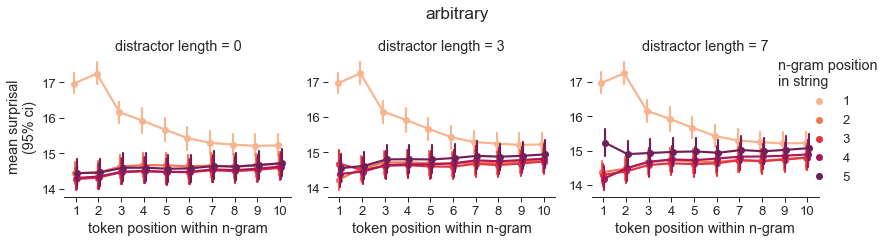

In [143]:
sns.set_style("ticks")
title=selected_list.split("-")[-1].replace("random", "arbitrary")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len == 10) & (data.dist_len.isin([0, 3, 7]))], 
                kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within n-gram", "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin string")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);

In [144]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\rnn_ngram-random_per_position


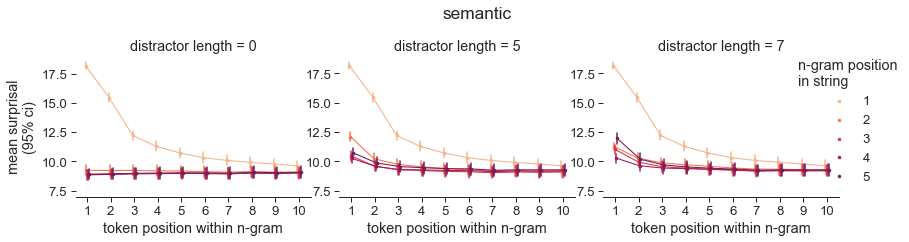

In [145]:
sns.set_style("ticks")
selected_list="ngram-categorized"
title=selected_list.split("-")[-1].replace("categorized", "semantic")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len == 10) & (data.dist_len.isin([0, 5, 7]))], 
                kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False, scale=0.5, errwidth=1.5,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 3)
for a in p.fig.axes:
    a.set_ylim((7, a.get_ylim()[-1]))
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within n-gram", "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin string")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);

In [146]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\rnn_ngram-categorized_per_position


### Plot per token position (gpt-2)

In [147]:
data = gpt.loc[gpt.marker==1]

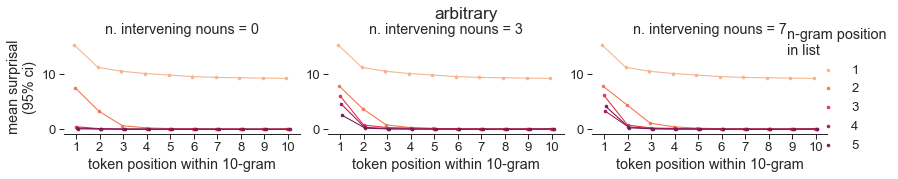

In [148]:
ngram=10
selected_list="ngram-random"
title=selected_list.split("-")[-1].replace("random", "arbitrary")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len==ngram) & (data.dist_len.isin([0, 3, 7]))], kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False, scale=0.5, errwidth=1.2,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 2)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within {}-gram".format(ngram), "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin list")
p.set_titles("n. intervening nouns = {col_name}")
p.despine(left=True);

In [149]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\gpt_ngram-random_per_position


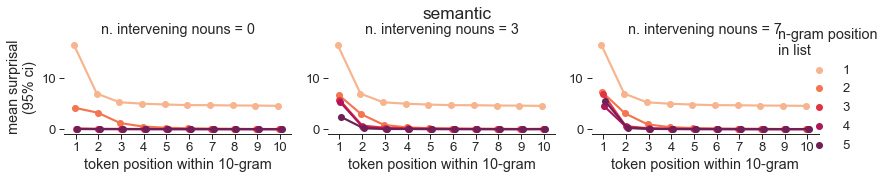

In [150]:
ngram=10
selected_list="ngram-categorized"
title=selected_list.split("-")[-1].replace("categorized", "semantic")
p2 = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len==ngram) & (data.dist_len.isin([0, 3, 7]))], 
                kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p2.fig.set_size_inches(12, 2)  
p2.fig.subplots_adjust(top=0.75)
p2.fig.suptitle(title)
p2.set_axis_labels("token position within {}-gram".format(ngram), "mean surprisal\n(95% ci)")
p2._legend.set_title(title="n-gram position\nin list")
p2.set_titles("n. intervening nouns = {col_name}")
p2.despine(left=True);

In [151]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}_per_position".format(selected_list)))
    p2.savefig(os.path.join(savedir, "gpt_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p2.savefig(os.path.join(savedir, "gpt_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

Saving \Users\karmeni1\project\lm-mem\fig\cshift\gpt_ngram-categorized_per_position


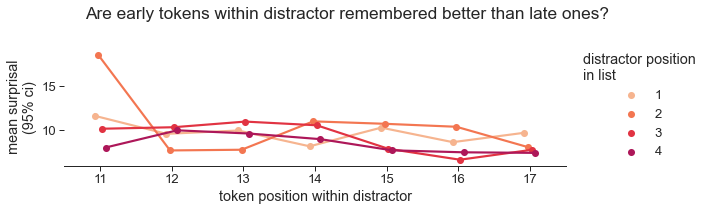

In [152]:
ngram=10
data=gpt.loc[gpt.marker==2]
p = sns.catplot(data=data.loc[(data.ngram_len==ngram) & (data.dist_len==7)], kind="point", x="token_pos", y="surp", hue="ngram_pos",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(10, 2.5)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle("Are early tokens within distractor remembered better than late ones?")
p.set_axis_labels("token position within distractor", "mean surprisal\n(95% ci)".format(ngram))
p._legend.set_title(title="distractor position\nin list")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);